In [1]:
### Mounting Google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
## Import libraries
import numpy as np
import pandas as pd
import sys
import logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns

seed = 42 #### for reproducibility

# Data

In [3]:
## example
example_path = "/gdrive/MyDrive/CSI/Notebook/datasets/Activity Recognition from Single Chest-Mounted Accelerometer/1.csv"
sample = pd.read_csv(example_path,header=None)
sample.columns = ["pos","x","y","z","action"]
sample.head(20)


,pos,x,y,z,action
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1
5,5.0,1604,1959,1921,1
6,6.0,1640,1829,1940,1
7,7.0,1607,1910,1910,1
8,8.0,1546,2045,1910,1
9,9.0,1529,2049,1972,1


In [4]:
def calculate_params(matrix):
    """
    Extracts 18 features from the three accelerometer
    axes (x, y, zù).

    ----------
    INPUT
    ----------
    matrix :
        Array of shape (N, 4), where:
        - columns 0, 1, 2 contain accelerometer values (x, y, z)
        - column 3 contains the activity label
        - N is the number of samples in the input window

    ----------
    OUTPUT
    ----------
    params :
        A list of 19 values:
        - 18 features (6 per axis: x, y, z):
            * mean
            * standard deviation
            * 25th percentile
            * 50th percentile (median)
            * 75th percentile
            * spectral energy (FFT-based)
        - 1 final value: the activity label (taken from matrix[0, 3])

        Total: 18 features + 1 label = 19 output values.
    """
    params = []
    for i in range(matrix.shape[1] - 1):
      ### 6 features for each axis --> 6x3 = 18 features in output
        mean = np.mean(matrix[:,i])
        std = np.std(matrix[:,i])
        perc25 = np.percentile(matrix[:,i],25)
        perc50 = np.percentile(matrix[:,i],50)
        perc75 = np.percentile(matrix[:,i],75)
        f = np.fft.fft(matrix[:,i])
        spEnergy = np.sum(f**2)/len(f)
        params.append(mean)
        params.append(std)
        params.append(perc25)
        params.append(perc50)
        params.append(perc75)
        params.append(spEnergy)

    params.append(matrix[0,3])
    return params

In [5]:
num_participants = 15

def import_accelerometer():
    # List to store the 15 dataframes
    dataframes = []
    for i in range(num_participants):
        # File path
        string = "/gdrive/MyDrive/CSI/Notebook/datasets/Activity Recognition from Single Chest-Mounted Accelerometer/" + str(i+1) + ".csv"

        # Read CSV
        dataframes.append(pd.read_csv(string, header=None))
        dataframes[i].columns = ["pos", "x", "y", "z", "action"]

    # Remove the "pos" column from each dataframe
    for i, dataframe in enumerate(dataframes):
        dataframes[i] = dataframe.drop("pos", axis=1)

    dataset = np.zeros((1, 19))
    # Process each dataframe
    for dataframe in dataframes:
        matrix = dataframe.to_numpy()

        # Split data of each participant into 7 matrices, one for each action class
        matrices = []
        matrices.append(matrix[matrix[:, 3] == 1])
        matrices.append(matrix[matrix[:, 3] == 2])
        matrices.append(matrix[matrix[:, 3] == 3])
        matrices.append(matrix[matrix[:, 3] == 4])
        matrices.append(matrix[matrix[:, 3] == 5])
        matrices.append(matrix[matrix[:, 3] == 6])
        matrices.append(matrix[matrix[:, 3] == 7])

        # Process each activity class
        for i, matrix in enumerate(matrices):

            # For all classes except class 2: use sliding windows of 1000 samples
            if i != 1:
                stop = False
                index = 0
                while not stop:

                    # If the next window goes beyond the matrix length I use less than 1000 sample for that window
                    if index + 1000 > matrix.shape[0]:
                        sample = matrix[index:matrix.shape[0]]
                        if sample.shape[0] != 0:
                            features = calculate_params(sample)
                        stop = True
                    else:
                        # Extract a 1000-sample window
                        sample = matrix[index:index + 1000]
                        features = calculate_params(sample)

                    index += 1000

                    # Append extracted features to the dataset
                    dataset = np.insert(dataset, dataset.shape[0], features, axis=0)

            # Special case: activity class 2 → use whole matrix without windowing (due to small number of samples for class 2)
            else:
                sample = matrix
                features = calculate_params(sample)
                dataset = np.insert(dataset, dataset.shape[0], features, axis=0)

    dataset = np.delete(dataset, 0, 0)
    ### dataset.shape = (number_of_windows, 19) --> 18 features + 1 corresponding label (last column)
    np.random.seed(seed)
    np.random.shuffle(dataset)

    ## 70% train / 10% validation / 20% test
    n_samples = dataset.shape[0]
    X_train = dataset[:int(0.7 * n_samples), :18]
    Y_train = dataset[:int(0.7 * n_samples), 18] - 1

    X_val = dataset[int(0.7 * n_samples):int(0.8 * n_samples), :18]
    Y_val = dataset[int(0.7 * n_samples):int(0.8 * n_samples), 18] - 1

    X_test = dataset[int(0.8 * n_samples):, :18]
    Y_test = dataset[int(0.8 * n_samples):, 18] - 1

    ### Normalization ###
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


In [6]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = import_accelerometer()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:5718: ComplexWarning: Casting complex values to real discards the imaginary part
  values = array(values, copy=None, ndmin=arr.ndim, dtype=arr.dtype)


In [9]:
print(f'Shape of X_train:{X_train.shape}')
print(f'Shape of X_val:{X_val.shape}')
print(f'Shape of X_test:{X_test.shape}')
print(f'Shape of Y_train:{Y_train.shape}')
print(f'Shape of Y_val:{Y_val.shape}')
print(f'Shape of Y_test:{Y_test.shape}')

Shape of X_train:(1353, 18)
Shape of X_val:(194, 18)
Shape of X_test:(387, 18)
Shape of Y_train:(1353,)
Shape of Y_val:(194,)
Shape of Y_test:(387,)


## Random Forest

In [8]:
n_estimators = [50, 100, 150, 200]
max_depth = [3, 5, 7, 9]

results = np.zeros((len(n_estimators), len(max_depth))) ## results matrix

## manual gridsearch for hyperparameters optimization
for i, n in enumerate(n_estimators):
    for j, d in enumerate(max_depth):
        classifier = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=seed) ## model definition
        classifier.fit(X_train, Y_train)  ### model training

        score = classifier.score(X_val, Y_val)
        results[i, j] = score   ## saving the results for the current hyperparameters combination

df_results = pd.DataFrame(results, index=[f"n={n}" for n in n_estimators], columns=[f"d={d}" for d in max_depth])

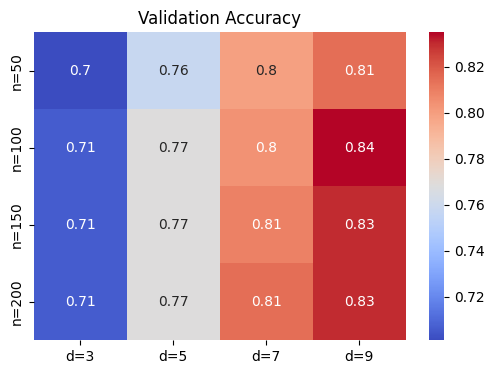


Best hyperparameters:
n_estimators = 100
max_depth = 9
Validation accuracy = 0.8351
Test accuracy = 0.8062


In [9]:
## heatmap plot
plt.figure(figsize=(6,4))
sns.heatmap(df_results, annot=True, cmap="coolwarm")
plt.title("Validation Accuracy")
plt.show()

# find the best combination of hyperparameters --> highest performance with validation data
best_idx = np.unravel_index(np.argmax(results), results.shape)
best_n = n_estimators[best_idx[0]]
best_d = max_depth[best_idx[1]]
best_score = results[best_idx]

print("\nBest hyperparameters:")
print(f"n_estimators = {best_n}")
print(f"max_depth = {best_d}")
print(f"Validation accuracy = {best_score:.4f}")

best_params = {
    "n_estimators": best_n,
    "max_depth": best_d,
    "val_accuracy": best_score
}

# definition of the best model
best_model = RandomForestClassifier(n_estimators=best_n, max_depth=best_d, random_state=seed)
best_model.fit(X_train, Y_train)

### Testing of the best model
test_score = best_model.score(X_test, Y_test)
print(f'Test accuracy = {test_score:.4f}')


## Gradient Boosting

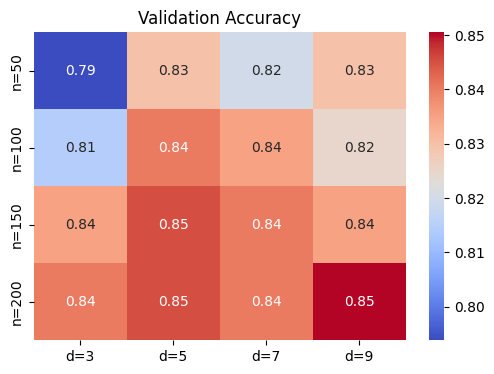


Best hyperparameters:
n_estimators = 200
max_depth = 9
Validation accuracy = 0.8505
Test accuracy = 0.8165


In [16]:
n_estimators = [50, 100, 150, 200]
max_depth = [3, 5, 7, 9]

results = np.zeros((len(n_estimators), len(max_depth))) ## results matrix

## manual gridsearch
for i, n in enumerate(n_estimators):
    for j, d in enumerate(max_depth):
        classifier = GradientBoostingClassifier(n_estimators=n, max_depth=d, random_state=seed) ## model definition
        classifier.fit(X_train, Y_train)  ### model training

        score = classifier.score(X_val, Y_val)
        results[i, j] = score   ## saving the results for the current hyperparameters combination

## df for heatmap
df_results = pd.DataFrame(results, index=[f"n={n}" for n in n_estimators], columns=[f"d={d}" for d in max_depth])

## heatmap plot
plt.figure(figsize=(6,4))
sns.heatmap(df_results, annot=True, cmap="coolwarm")
plt.title("Validation Accuracy")
plt.show()

# find the best combination of hyperparameters --> highest performance with validation data
best_idx = np.unravel_index(np.argmax(results), results.shape)
best_n = n_estimators[best_idx[0]]
best_d = max_depth[best_idx[1]]
best_score = results[best_idx]

print("\nBest hyperparameters:")
print(f"n_estimators = {best_n}")
print(f"max_depth = {best_d}")
print(f"Validation accuracy = {best_score:.4f}")

best_params = {
    "n_estimators": best_n,
    "max_depth": best_d,
    "val_accuracy": best_score
}

# definition of the best model
best_model = GradientBoostingClassifier(n_estimators=best_n, max_depth=best_d, random_state=seed)
best_model.fit(X_train, Y_train)

### Testing of the best model
test_score = best_model.score(X_test, Y_test)
print(f'Test accuracy = {test_score:.4f}')